In [1]:
# Basic Imports
import numpy as np
import h5py as h5
#from sklearn.externals import joblib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.cross_validation import KFold
import pickle
import re
import collections
import tables as tb
import ipyparallel as ipp
from sklearn import preprocessing

In [2]:
#datasets

#input data
train_val_file = '/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_seg_fused_train_plus_val.pkl'
test_file = '/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_seg_fused_test.pkl'

#k-fold indices (from a saved file)
kf_file = "/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_train_valid_KFold_idx.pkl"

#save dir for trained model 
CV_model_dir = '/projects/nikhil/ADNI_prediction/models/CV_pkls/'

#inflated_train_val_file = '/projects/nikhil/ADNI_prediction/input_datasets/inflated_datasets/total_HC_vol_CT_inflated_CV_subsets_ROI_74.h5'
#sub_sampx_map_file = '/projects/nikhil/ADNI_prediction/input_datasets/HC_CT_inflated_CV_subsets.h5.pkl'
inflated_train_val_file = '/projects/nikhil/ADNI_prediction/input_datasets/PE_inflated_samples/total_HC_vol_CT_inflated_CV_subsets_MC5.h5'
sub_sampx_map_file = '/projects/nikhil/ADNI_prediction/input_datasets/HC_CT_inflated_CV_subsets_MC5.h5.pkl'

AAL_roi_Name_featID_file = '/projects/nikhil/ADNI_prediction/input_datasets/CT/AAL_ROI_Name_featIDx.pkl'


In [3]:
#Grab CV data with specific feature columes (independent vars) and specific clinical scale (dependent var)
def load_CV_data(in_file, kf_file, feature_cols, clinical_scale, scale_data):

    data = pd.read_pickle(in_file)
    data_trunc = data[['PTID','IID'] + clinical_scale + feature_cols]
    # remove nans
    print 'NaN shape: {}'.format(np.sum(np.isfinite(data_trunc[clinical_scale[0]])))
    data_trunc = data_trunc[np.isfinite(data_trunc[clinical_scale[0]])]
    X_raw = np.asarray(data_trunc[feature_cols],dtype=float)
    y = np.asarray(data_trunc[clinical_scale[0]],dtype=float)
    U = list(data_trunc['PTID'] + "_" + data_trunc['IID'])
    
    if scale_data:
        X = preprocessing.scale(X_raw)
    else:
        X = X_raw
        
    kf = pickle.load( open(kf_file, "rb" ) )
    X_train = []
    X_valid = []
    y_train = []
    y_valid = []
    U_train = []
    U_valid = []
    for train, valid in kf:        
        X_train.append(X[train])
        X_valid.append(X[valid])
        y_train.append(y[train])
        y_valid.append(y[valid])
        U_train.append([U[x] for x in train])
        U_valid.append([U[x] for x in valid])
        
    #print valid
    # Return train and validation lists comprising all folds as well as unsplit data
    return {'X_train':X_train,'X_valid':X_valid,'y_train':y_train,'y_valid':y_valid,'X':X,'y':y, 'U_train':U_train,'U_valid':U_valid,'UIDs':U}

def load_data(data_path, input_node):
    data = tb.open_file(data_path, 'r')
    X = data.get_node('/' + input_node)[:]
    data.close()
    return X

def load_inflated_CV_data(in_file,feature_cols,s_fold, e_fold, scale_data):
    X_train = []
    X_valid = []
    y_train = []
    y_valid = []
    for i in np.arange(s_fold,e_fold+1,1):
        for m,modality in enumerate(feature_cols):
            train_name = 'Fold_{}_train_X_{}'.format(i,modality)
            train_data = load_data(in_file, train_name)
            #valid_name = 'Fold_{}_valid_X_{}'.format(i,modality)
            #valid_data = load_data(in_file, valid_name)
            
            if modality in ['L_HC', 'R_HC']:
                train_data = train_data.reshape(train_data.shape[0],1)            
                #valid_data = valid_data.reshape(valid_data.shape[0],1)
                
            if m ==0:
                train_X = train_data
                #valid_X = valid_data
            else:                 
                train_X = np.hstack((train_X, train_data))
                #valid_X = np.hstack((valid_X, valid_data))
            
        if scale_data:
            train_X_scaled = preprocessing.scale(train_X)
        else:
            train_X_scaled = train_X
                
        X_train.append(train_X_scaled)
        #X_valid.append(valid_X)
        
        train_y = load_data(in_file, 'Fold_{}_train_y'.format(i))
        #valid_y = load_data(in_file, 'Fold_{}_valid_y'.format(i))
        
        y_train.append(train_y)
        #y_valid.append(valid_y)
    
    return {'X_train':X_train,'X_valid':X_valid,'y_train':y_train,'y_valid':y_valid}
        
#Load test data
def load_test_data(in_file, feature_cols, clinical_scale):

    data = pd.read_pickle(in_file)
    data_trunc = data[['PTID','IID'] + clinical_scale + feature_cols]
    # remove nans
    print 'NaN shape: {}'.format(np.sum(np.isfinite(data_trunc[clinical_scale[0]])))
    data_trunc = data_trunc[np.isfinite(data_trunc[clinical_scale[0]])]
    U = list(data_trunc['PTID'] + "_" + data_trunc['IID'])
    
    X_raw = np.asarray(data_trunc[feature_cols],dtype=float)
    
    if scale_data:
        X = preprocessing.scale(X_raw)
    else:
        X = X_raw
        
    y = np.asarray(data_trunc[clinical_scale[0]],dtype=float)
    return {'X':X, 'y':y, 'U':U}

def innerCVLoop(model_clf,hyper_params,fold_X, fold_y,save_model,save_model_path):
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    clf = grid_search.GridSearchCV(model_clf, hyper_params,cv=3,verbose=0)
    clf.fit(fold_X, fold_y)
    #Save classifier
    if save_model:
        save_model(clf,save_model_path)
        
    return clf

def save_classifier(clf,save_model_path):
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    save_model_filename = save_model_path + '_' + st + '.pkl'
        
    f = open(save_model_filename, 'wb')
    pickle.dump(clf, f)
    f.close()

In [88]:
# Baseline models with non-inflated training data
# Grab specific columns as features from the original table
data = pd.read_pickle(train_val_file)
data_cols = data.columns
#regex=re.compile(".*(CT_).*")
#CT_cols_raw = [m.group(0) for l in data_cols for m in [regex.search(l)] if m] 
#print len(CT_cols_raw)
#print CT_cols_raw

CT_name_featID_dict = pd.read_pickle(AAL_roi_Name_featID_file)
CT_vals = CT_name_featID_dict.values()
#print len(CT_cols)
#print CT_cols
CT_cols = []
for ct in CT_vals:
    CT_cols.append('CT_' + ct.strip())    

#print CT_cols
regex=re.compile(".*(_HC_)(\d+)")
HC_cols = [m.group(0) for l in data_cols for m in [regex.search(l)] if m] 

modality = 'CT'
if modality == 'HC_CT':
    feature_cols = ['L_HC_VOL','R_HC_VOL'] + CT_cols
elif modality == 'HC':
    feature_cols = ['L_HC_VOL','R_HC_VOL'] 
elif modality == 'CT':
    feature_cols = CT_cols
else:
    print "invalid modality choice"

clinical_scale = ['ADAS13']
#clinical_scale = ['MMSE']

scale_data = True
cv_data = load_CV_data(train_val_file,kf_file, feature_cols, clinical_scale, scale_data)
test_data = load_test_data(test_file, feature_cols, clinical_scale)

#Data stats for QC
print cv_data['X'].shape, test_data['X'].shape
print 'L_HC corr: {}'.format(stats.pearsonr(np.sum(cv_data['X'][:,:1],axis=1),cv_data['y']))
print 'R_HC corr: {}'.format(stats.pearsonr(np.sum(cv_data['X'][:,1:1+1],axis=1),cv_data['y']))
print 'L_HC mean vol {}:'.format(np.mean(np.sum(cv_data['X'][:,:1],axis=1)))
print 'R_HC mean vol {}:'.format(np.mean(np.sum(cv_data['X'][:,1:1+1],axis=1)))

print 'L_HC corr: {}'.format(stats.pearsonr(cv_data['X_valid'][0][:,0],cv_data['y_valid'][0]))
print 'R_HC corr: {}'.format(stats.pearsonr(cv_data['X_valid'][0][:,1],cv_data['y_valid'][0]))

print 'means {}:'.format(np.mean(cv_data['X_valid'][0],axis=0))


NaN shape: 581
NaN shape: 110
(581, 74) (110, 74)
L_HC corr: (-0.15139291390678625, 0.00024982642489064483)
R_HC corr: (-0.071183414728894251, 0.086477156783943798)
L_HC mean vol 2.17076309118e-16:
R_HC mean vol 6.19126092906e-16:
L_HC corr: (-0.20980207854372418, 0.11074661281984115)
R_HC corr: (-0.18131162948779028, 0.16934728298648061)
means [-0.06091574 -0.09880099 -0.24677161 -0.21301598 -0.09804138 -0.2019871
 -0.24279321 -0.23196416 -0.14887655 -0.14913244 -0.0544271  -0.12871792
 -0.19425334 -0.15533029 -0.03717398 -0.07141455 -0.07602697 -0.06297485
 -0.16559758 -0.19952026 -0.16309035 -0.16868303 -0.24505186 -0.25349496
 -0.13186926 -0.26297326 -0.0631167  -0.23921079 -0.19442544 -0.14409193
 -0.12152828 -0.13636433 -0.18823523 -0.21729875 -0.02038136 -0.07515137
  0.00569746 -0.02888871 -0.09269123 -0.19314016 -0.01138153 -0.02580597
 -0.01845431 -0.03906404  0.02251856  0.00939497 -0.04924524 -0.15439804
 -0.06954564 -0.07143533  0.00435793  0.00348602  0.04827803 -0.070891

In [ ]:
#Sanity check!
new_fused_data = h5.File('/projects/nikhil/ADNI_prediction/input_datasets/HC_CT_fused_CV_subsets_C688_valid.h5','r')
new_inflated_data = h5.File('/projects/nikhil/ADNI_prediction/input_datasets/inflated_datasets_C688/HC_CT_inflated_CV_OuterFold_1_valid_InnerFold_1_partition_ROI_74.h5','r')
#new_inflated_data = h5.File('/scratch/nikhil/ADNI_prediction_data_bkup/HC_CT_inflated_CV_subsets_C688.h5','r')
#new_fused_data = h5.File('/scratch/nikhil/ADNI_prediction_data_bkup/HC_CT_fused_CV_subsets_C688.h5','r')

Fold_1_X_L_HC_fused = new_fused_data['Fold_1_X_L_HC'][:]
Fold_1_X_R_HC_fused = new_fused_data['Fold_1_X_R_HC'][:]
Fold_1_X_R_CT_fused = new_fused_data['Fold_1_X_R_CT'][:]
Fold_1_y_fused = new_fused_data['Fold_1_y'][:]

Fold_1_X_L_HC_infl = new_inflated_data['Fold_1_X_L_HC'][:]
Fold_1_X_R_HC_infl = new_inflated_data['Fold_1_X_R_HC'][:]
Fold_1_X_R_CT_infl = new_inflated_data['Fold_1_X_R_CT'][:]
Fold_1_y_infl = new_inflated_data['Fold_1_y'][:]


#infl_data = new_inflated_data['Fold_1_train_X'][:]
#Fold_1_X_L_HC_infl = infl_data[:,:11427]
#Fold_1_X_R_HC_infl = infl_data[:,11427:11427+10519]
#Fold_1_X_R_CT_infl = infl_data[:,11427+10519:]
#Fold_1_y_infl = new_inflated_data['Fold_1_train_y'][:]

new_fused_data.close()
new_inflated_data.close()
print Fold_1_X_L_HC_fused.shape, Fold_1_X_L_HC_infl.shape
print 'L_HC corr: {}'.format(stats.pearsonr(np.sum(Fold_1_X_L_HC_fused,axis=1),Fold_1_y_fused))
print 'R_HC corr: {}'.format(stats.pearsonr(np.sum(Fold_1_X_R_HC_fused,axis=1),Fold_1_y_fused))
print 'L_HC mean vol {}:'.format(np.mean(np.sum(Fold_1_X_L_HC_fused,axis=1)))
print 'R_HC mean vol {}:'.format(np.mean(np.sum(Fold_1_X_R_HC_fused,axis=1)))

print 'L_HC corr: {}'.format(stats.pearsonr(np.sum(Fold_1_X_L_HC_infl,axis=1),Fold_1_y_infl))
print 'R_HC corr: {}'.format(stats.pearsonr(np.sum(Fold_1_X_R_HC_infl,axis=1),Fold_1_y_infl))
print 'L_HC mean vol {}:'.format(np.mean(np.sum(Fold_1_X_L_HC_infl,axis=1)))
print 'R_HC mean vol {}:'.format(np.mean(np.sum(Fold_1_X_R_HC_infl,axis=1)))

print Fold_1_X_R_CT_fused.shape, Fold_1_X_R_CT_infl.shape
ct_feat = Fold_1_X_R_CT_fused.shape[1]
x = np.arange(ct_feat)
ym_f = np.mean(Fold_1_X_R_CT_fused,axis=0)
ym_i = np.mean(Fold_1_X_R_CT_infl,axis=0)
ye = stats.sem(Fold_1_X_R_CT_fused, axis=0)

cv_data_r = []
cv_data_inflated_r = []
for i in np.arange(ct_feat):
    cv_data_r.append(stats.pearsonr(Fold_1_X_R_CT_fused[:,i], Fold_1_y_fused))        
    cv_data_inflated_r.append(stats.pearsonr(Fold_1_X_R_CT_infl[:,i],Fold_1_y_infl))
                               
r_diff = np.array(zip(*cv_data_r)[0]) - np.array(zip(*cv_data_inflated_r)[0])
    
plt.figure()
plt.subplot(2,1,1)
plt.plot(ym_f-ym_i, label='diff')
#plt.errorbar(x[2:],ct_data_inflated_roi_mean[2:],yerr=ct_data_inflated_roi_std_err[2:],label='inflated')
plt.subplot(2,1,2)
plt.plot(r_diff ,label='diff')
#plt.plot(zip(*cv_data_r)[0] - zip(*cv_data_inflated_r)[0] ,label='diff')
#plt.plot(zip(*cv_data_inflated_r)[0],label='inflated')
plt.legend()
plt.show()

In [ ]:
print Fold_1_y_fused
print cv_data['y_valid'][0]

In [ ]:
# Baseline models with inflated training data
feature_cols_inflated = ['L_HC', 'R_HC', 'CT']
#feature_cols_inflated = ['CT']

#Temp Change due to mismatch in CT columns
scale_data = True
cv_data_inflated = load_inflated_CV_data(inflated_train_val_file, feature_cols_inflated,1, 10, scale_data)

HC_offset = 0 # if only using CT features

#X_train_list = []
#ignore_list_CT_idx = list(HC_offset + np.array([0,29,30,37,38]))
#for X_train in cv_data_inflated_raw['X_train']:
#    X_train_list.append(np.delete(X_train, np.s_[ignore_list_CT_idx], 1))
        
#cv_data_inflated = {'X_train':X_train_list,'y_train':cv_data_inflated_raw['y_train']}
#######  

#Data stats for QC
print cv_data_inflated['X_train'][0].shape
print 'L_HC corr: {}'.format(stats.pearsonr((cv_data_inflated['X_train'][0][:,0]),cv_data_inflated['y_train'][0]))
print 'R_HC corr: {}'.format(stats.pearsonr((cv_data_inflated['X_train'][0][:,1]),cv_data_inflated['y_train'][0]))
print 'L_HC mean vol {}:'.format(np.mean((cv_data_inflated['X_train'][0][:,0])))
print 'R_HC mean vol {}:'.format(np.mean((cv_data_inflated['X_train'][0][:,1])))

#sub_sampx_dict_list = pickle.load( open(sub_sampx_map_file, "rb" ) )




In [ ]:
print cv_data['y_train'][0][:100]
print cv_data_inflated['y_train'][0][:100]

for f in np.arange(10):
    verify=[]
    pointer=0

    d = sub_sampx_dict_list[f]
    keys = d.keys()

    #print len(d)

    for ind, y1 in enumerate(cv_data['y_train'][f]):
        #print d[keys[ind]]
        y2 = cv_data_inflated['y_train'][f][pointer:pointer+d[keys[ind]]]
        pointer = pointer+sub_sampx_dict_list[f][keys[ind]]
        #print 'y1 {}, y2 {}, verify: {}'.format(y1,np.mean(y2),(float(y1)-float(np.mean(y2))))
        verify.append(np.round(y1-np.mean(y2)))
    
   # print np.sum(verify)

#print sub_sampx_dict_list[0]
#print (cv_data['U_train'][0])

#for f in np.arange(10):
#    a = sorted(sub_sampx_dict_list[f].keys())
#    b = sorted(cv_data['U_train'][f])
#    c = sorted(cv_data['U_valid'][f])
#    print set(a) == set(b)
#    print set(c) & set(b)



In [ ]:
ct_data_roi_mean = np.mean(cv_data['X'],axis=0)
ct_data_inflated_roi_mean = np.mean(cv_data_inflated['X_train'][0],axis=0)
ct_data_roi_std_err = stats.sem(cv_data['X'],axis=0)
ct_data_inflated_roi_std_err = stats.sem(cv_data_inflated['X_train'][0],axis=0)
x=np.arange(len(feature_cols))
cv_data_r = []
cv_data_inflated_r = []


for i in np.arange(len(feature_cols)):
    cv_data_r.append(stats.pearsonr(cv_data['X'][:,i], cv_data['y']))        
    cv_data_inflated_r.append(stats.pearsonr(cv_data_inflated['X_train'][0][:,i],cv_data_inflated['y_train'][0]))
                               
                               
print np.shape(ct_data_roi_mean),np.shape(ct_data_inflated_roi_mean)

plt.figure()
plt.style.use('ggplot')
plt.subplot(2,1,1)
plt.errorbar(x[2:],ct_data_inflated_roi_mean[2:]-ct_data_roi_mean[2:],yerr=ct_data_roi_std_err[2:],label='diff')
#plt.errorbar(x[2:],ct_data_inflated_roi_mean[2:],yerr=ct_data_inflated_roi_std_err[2:],label='inflated')
plt.subplot(2,1,2)
plt.plot(zip(*cv_data_r)[0],label='basic')
plt.plot(zip(*cv_data_inflated_r)[0],label='inflated')
plt.legend()
plt.show()


In [ ]:
# Use this data for computing subject wise performance during outerloop cross-validation + held-out testset
fused_data_dir = '/projects/nikhil/ADNI_prediction/input_datasets/'
CV_fused_file = 'HC_CT_inflated_CV_OuterFolds_valid_partition_fused.h5'
test_fused_file = 'HC_CT_inflated_CV_OuterFolds_test_partition_fused.h5'

CV = True
L_HC_offset=11427
R_HC_offset=10519

if CV:
    cv_data_valid_X = cv_data['X_valid']     
    cv_data_valid_y = cv_data['y_valid']

    CV_fused_data = h5.File(fused_data_dir + CV_fused_file,'a')
    for f in np.arange(10):
        all_data = cv_data_valid_X[f]
        CV_fused_data.create_dataset('Fold_{}_X_L_HC'.format(f+1),data=all_data[:,:L_HC_offset])
        CV_fused_data.create_dataset('Fold_{}_X_R_HC'.format(f+1),data=all_data[:,L_HC_offset:L_HC_offset+R_HC_offset])
        CV_fused_data.create_dataset('Fold_{}_X_R_CT'.format(f+1),data=all_data[:,L_HC_offset+R_HC_offset:])#Typo : R_CT
        CV_fused_data.create_dataset('Fold_{}_y'.format(f+1),data=cv_data_valid_y[f])
    
    CV_fused_data.close()

else:
    test_fused_data = h5.File(fused_data_dir + test_fused_file,'a')
    all_data = test_data['X']
    test_fused_data.create_dataset('heldout_X_L_HC',data=all_data[:,:L_HC_offset])
    test_fused_data.create_dataset('heldout_X_R_HC',data=all_data[:,L_HC_offset:L_HC_offset+R_HC_offset])
    test_fused_data.create_dataset('heldout_X_CT',data=all_data[:,L_HC_offset+R_HC_offset:])    
    test_fused_data.create_dataset('heldout_y',data=test_data['y'])
    test_fused_data.close()


In [92]:
# K-fold validations (nested)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import grid_search
import datetime
import time
import collections
from scipy.stats import mode
from sklearn.metrics import mean_squared_error as mse

model_list = ['LR', 'LR_L1', 'SVR', 'RFR']
model_choice_id = 2
model_choice = model_list[model_choice_id]
inflated_train = False

if model_choice == 'LR':
    model_clf = LinearRegression()   
    inner_loop = False #only needed to optimize hyper-params
    feat_imp = False
    if inflated_train:
        print "no trained model yet"
    else:
        saved_model_name = 'LR_2015-10-13-16-38-28.pkl'
    
elif model_choice == 'LR_L1':
    model_clf = Lasso()
    hyper_params = {'alpha':[0.2, 0.1, 0.05, 0.01]} 
    inner_loop = True #only needed to optimize hyper-params
    feat_imp = True
    if clinical_scale[0] == 'ADAS13':
        if inflated_train:
            saved_model_name = 'LR_L1_ADAS13_inflated_train_parallel_2015-11-14-20-21-48.pkl'
        else:
            saved_model_name = 'LR_L1_ADAS13_2015-11-06-12-25-21.pkl'
    else:
        saved_model_name = 'LR_L1_MMSE_2015-10-16-16-27-29.pkl'
    
elif model_choice == 'SVR':
    model_clf = SVR()
    hyper_params = {'kernel':['linear','rbf'], 'C':[1,10]}
    inner_loop = True #only needed to optimize hyper-params
    feat_imp = True
    if clinical_scale[0] == 'ADAS13':
        if inflated_train:
            saved_model_name = 'SVR_ADAS13_inflated_train_parallel_2015-11-27-18-43-41.pkl'
        else:
            saved_model_name = 'SVR_ADAS13_2015-11-27-18-48-33.pkl'
    else:
        saved_model_name = 'SVR_MMSE_2015-10-16-18-02-11.pkl'
    
elif model_choice == 'RFR':
    model_clf = RandomForestRegressor(n_jobs=6)
    hyper_params = {'n_estimators':[10,50,100,200,500],'min_samples_split':[2,4,8]}
    #hyper_params = {'min_samples_split':[2,4,8,16]}
    inner_loop = True #only needed to optimize hyper-params
    feat_imp = True
    if clinical_scale[0] == 'ADAS13':
        if inflated_train:
            #saved_model_name = 'RFR_ADAS13_inflated_train_parallel_2015-11-10-15-01-42.pkl'
            saved_model_name = 'RFR_ADAS13_inflated_train_parallel_2015-11-16-14-21-15.pkl'
        else:
            saved_model_name = 'RFR_ADAS13_2015-11-05-18-02-11.pkl'
    else:
        saved_model_name = 'RFR_MMSE_2015-10-16-16-22-42.pkl'
else:
    print "Unknown model choice"

In [6]:
#Outer Fold Computation

def computeOuterFold(train_X, train_y, valid_X, valid_y, model_clf, hyper_params, inner_loop, save_model, save_model_path):
    import collections
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    import datetime
    import time
    import collections
    from scipy.stats import mode
    from sklearn.metrics import mean_squared_error as mse
    from scipy import stats
    
    print 'Starting Outerfold computation'
    
    hp_dict = collections.defaultdict(list) #store best hyper-parameters for each fold
    
    if inner_loop:     
        print 'Starting Inner computation'
        save_model_path_fold = save_model_path + '_fold_' 
        clf = innerCVLoop(model_clf,hyper_params,train_X, train_y,save_model,save_model_path_fold)
        for hp in hyper_params:
            hp_dict[hp].append(clf.best_estimator_.get_params()[hp])
            
        print 'Ending InnerFold computation'

    else:
        clf = model_clf
        clf.fit(fold_X,fold_y)
        
    #CV_scores    
    r_train = stats.pearsonr(clf.predict(train_X),train_y)
    r_valid = stats.pearsonr(clf.predict(valid_X),valid_y)
        
    R2_train = clf.score(train_X,train_y) 
    R2_valid = clf.score(valid_X,valid_y)
        
    MSE_train = mse(clf.predict(train_X),train_y)
    MSE_valid = mse(clf.predict(valid_X),valid_y)
    
    print 'Ending OuterFold computation'
    
    return {'r_train':r_train, 'r_valid':r_valid, 'R2_train':R2_train, 'R2_valid':R2_valid,
            'MSE_train':MSE_train, 'MSE_valid':MSE_valid, 'hp_dict':hp_dict, 
            'predicted_fold_score': clf.predict(valid_X), 'actual_fold_scores':valid_y}

In [93]:
#Parallelize!!! 
from functools import partial

inflated_train = False

save_model_path = CV_model_dir + model_choice + '_' + clinical_scale[0]
load_model_path = CV_model_dir + saved_model_name

# train a new classifer? (if false then load a single pretrained classifier based on most frequent hyperparams found previously
# This will NOT load N different classifiers each for outer-CV fold  
train_clf = True

if inflated_train:    
    cv_X_train = cv_data_inflated['X_train']
    cv_y_train = cv_data_inflated['y_train']
else: 
    cv_X_train = cv_data['X_train']
    cv_y_train = cv_data['y_train']
    
cv_X_valid = cv_data['X_valid']
cv_y_valid = cv_data['y_valid']

#print cv_y_valid

no_of_folds = len(cv_X_train)

save_model = False #do you want to save all classifiers per each fold? 
save_model_path = CV_model_dir + model_choice + '_' + clinical_scale[0]

if train_clf:
    CV_r_train=[] #pearson r score for each outer fold on train set
    CV_r_valid=[] #pearson r score for each outer fold on validation set

    CV_R2_train=[] #R2 score for each outer fold on train set
    CV_R2_valid=[] #R2 score for each outer fold on validation set

    CV_MSE_train=[] #MSE for each outer fold on train set
    CV_MSE_valid=[] #MSE for each outer fold on validation set
    
    predicted_CV_scores = []
    actual_CV_scores = []
    # outer CV loop     
    rc = ipp.Client()
    dview = rc[:]
    dview.push(dict(computeOuterFold = computeOuterFold))
    dview.push(dict(innerCVLoop = innerCVLoop))
    mapfunc = partial(computeOuterFold, model_clf=model_clf, hyper_params=hyper_params, inner_loop=inner_loop, 
                  save_model=save_model, save_model_path=save_model_path)
    parallel_result = dview.map_sync(mapfunc, cv_X_train,cv_y_train,cv_X_valid,cv_y_valid)    
    hp_dict = collections.defaultdict(list)
    for pr in parallel_result:
        CV_r_train.append(pr['r_train'])
        CV_r_valid.append(pr['r_valid'])
        CV_R2_train.append(pr['R2_train'])
        CV_R2_valid.append(pr['R2_valid'])
        CV_MSE_train.append(pr['MSE_train'])
        CV_MSE_valid.append(pr['MSE_valid'])
        predicted_CV_scores.append(pr['predicted_fold_score'])
        actual_CV_scores.append(pr['actual_fold_scores'])
        
        for hp in hyper_params:
            hp_dict[hp].append(pr['hp_dict'][hp])
            
    #retrain model on the entire train + valid set with most frequent hyper-params during cross-val
    if inner_loop:
        hp_mode = {}
        for hp in hyper_params:
            hp_mode[hp] = mode(hp_dict[hp])[0][0]
            
        print 'most frequent hp:' + str(hp_mode)
    
else: 
    #Grabs the best classifer as a result of N-fold nested CV along with the MSE and R2 stats of the outerloop
    print "Loading previously saved model: "
    f = open(load_model_path)
    result = pickle.load(f)
    test_clf = result['best_clf']
    CV_r_valid = result['CV_r']
    CV_R2_valid = result['CV_R2']
    CV_MSE_valid = result['CV_MSE']
    f.close()

print 'CV r (mean, median, std_err): ' + '{:04.2f},{:04.2f},{:04.2f}'.format(np.mean(zip(*CV_r_valid)[0]),np.median(zip(*CV_r_valid)[0]),stats.sem(zip(*CV_r_valid)[0]))
print 'CV R2 (mean, median, std_err): ' + '{:04.2f},{:04.2f}, {:04.2f}'.format(np.mean(CV_R2_valid),np.median(CV_R2_valid),stats.sem(CV_R2_valid))
print 'CV MSE (mean, median, std_err): ' + '{:04.2f},{:04.2f}, {:04.2f}'.format(np.mean(CV_MSE_valid),np.median(CV_MSE_valid),stats.sem(CV_MSE_valid))

most frequent hp:{'kernel': array(['rbf'], 
      dtype='|S3'), 'C': array([10])}
CV r (mean, median, std_err): 0.48,0.46,0.03
CV R2 (mean, median, std_err): 0.19,0.19, 0.03
CV MSE (mean, median, std_err): 63.05,62.96, 2.60


In [94]:
# Evaluate the test set based on most frequnt hyper-params
if inflated_train:
    save_model_path = CV_model_dir + model_choice + '_' + clinical_scale[0] + '_inflated_train_parallel'
    exemplar_X = cv_X_train[0]
    exemplar_y = cv_y_train[0]        
else:
    exemplar_X = cv_data['X']
    exemplar_y = cv_data['y']
    save_model_path = CV_model_dir + model_choice + '_' + clinical_scale[0] + '_' + modality
        
if train_clf:
    #test_clf = LinearRegression()  
    #test_clf = Lasso(alpha=0.2)    
    test_clf = SVR(kernel='rbf',C=10)
    #test_clf = RandomForestRegressor(n_estimators=200,min_samples_split=4,n_jobs=4)
   
    save_model = True    
    
    test_clf.fit(exemplar_X,exemplar_y)
    if save_model:
        classifier_model_and_stats = {'best_clf':test_clf, 'CV_R2':CV_R2_valid, 'CV_MSE':CV_MSE_valid, 'CV_r': CV_r_valid,
                                     'predicted_CV_scores':predicted_CV_scores,'actual_CV_scores':actual_CV_scores}
        save_classifier(classifier_model_and_stats,save_model_path)

    # heldout set training perf
    pearson_r_train = stats.pearsonr(test_clf.predict(exemplar_X),exemplar_y)
    R2_train = test_clf.score(exemplar_X,exemplar_y)
    MSE_train = mse(test_clf.predict(exemplar_X),exemplar_y)
    
    print "train r: " + str(pearson_r_train)
    print "train R2 score: " + str(R2_train)
    print "test R2 score: " + str(MSE_train)

# heldout set test perf
predicted_score = test_clf.predict(test_data['X'])
actual_score = test_data['y']
pearson_r_test = stats.pearsonr(predicted_score,actual_score)
R2_test = test_clf.score(test_data['X'],actual_score)
MSE_test = mse(predicted_score,actual_score)

print "test r: " + str(pearson_r_test)
print "test R2: " + str(R2_test)
print "test MSE: " + str(MSE_test)

train r: (0.82855719067662903, 5.7504886312141541e-148)
train R2 score: 0.660035203933
test R2 score: 27.0881853244
test r: (0.443034856488974, 1.2547063012747533e-06)
test R2: 0.189389087448
test MSE: 68.0958433803


In [ ]:
save_plt_data = True
if save_plt_data: #save the data to be plotter later.. (montages etc..)
        montage_dir = '/projects/nikhil/ADNI_prediction/caffe_output/montage_data/'
        mydict = {'predicted_score': predicted_score, 'actual_score': actual_score}
        output = open('{}corr_data_{}_T{}.pkl'.format(montage_dir,model_choice+'_mmse',1), 'wb')
        pickle.dump(mydict, output)
        output.close()

In [100]:
load_saved_boxplots = True
if load_saved_boxplots:
    boxplot_config_r = collections.defaultdict(list)
    boxplot_config_R2 = collections.defaultdict(list)
    boxplot_config_MSE = collections.defaultdict(list)
    boxplots_dir = '/projects/nikhil/ADNI_prediction/models/CV_pkls/'
    scale = 'ADAS13'
    if scale == 'ADAS13':
        baseline_models = {'LR_HC_CT*': 'LR_L1_ADAS13HC_CT_2016-01-05-14-55-52.pkl',
                        'SVR_HC_CT*':'SVR_ADAS13HC_CT_2016-01-05-14-56-52.pkl', 
                        'RFR_HC_CT':'RFR_ADAS13HC_CT_2016-01-05-15-02-20.pkl', 
                        'LR_infl*': 'LR_L1_ADAS13_inflated_train_parallel_2015-11-27-18-28-55.pkl',
                        'SVR_infl*':'SVR_ADAS13_inflated_train_parallel_2015-11-27-18-43-41.pkl',
                        'RFR_infl':'RFR_ADAS13_inflated_train_parallel_2015-11-27-15-28-13.pkl',
                        'LR_HC*':'LR_L1_ADAS13_HC_2016-01-05-16-24-12.pkl',
                        'SVR_HC*':'SVR_ADAS13_HC_2016-01-05-16-24-45.pkl',
                        'RFR_HC':'RFR_ADAS13_HC_2016-01-05-16-26-41.pkl',
                        'LR_CT*':'LR_L1_ADAS13_CT_2016-01-05-16-30-30.pkl',
                        'SVR_CT*':'SVR_ADAS13_CT_2016-01-05-16-31-19.pkl',
                        'RFR_CT':'RFR_ADAS13_CT_2016-01-05-16-29-27.pkl'}
    if scale == 'MMSE':
        baseline_models = {'LR_L1*': 'LR_L1_MMSE_2015-12-29-16-41-41.pkl',
                        'SVR*':'RFR_MMSE_2015-12-29-17-35-51.pkl', 
                        'RFR':'SVR_MMSE_2015-12-29-17-40-24.pkl'}

    # Not plotted:
    # 'LR_L1': 'LR_L1_ADAS13_2015-11-06-12-25-21.pkl'
    # 'LR_L1_infl':'LR_L1_ADAS13_inflated_train_parallel_2015-11-27-15-05-17.pkl'
    r_means =  collections.defaultdict(list)    
    r_medians =  collections.defaultdict(list)    
    r_sems =  collections.defaultdict(list)
    mse_means =  collections.defaultdict(list)        
    mse_sems =  collections.defaultdict(list)
    predicted_CV_scores = collections.defaultdict(list) 
    actual_CV_scores = collections.defaultdict(list)
    keys_used = []
    for key,val in baseline_models.iteritems():
        pkl_file = open(boxplots_dir + val, 'rb')
        saved_data = pickle.load(pkl_file)
        pkl_file.close()            
        boxplot_config_r[key].append(zip(*saved_data['CV_r'])[0])
        boxplot_config_MSE[key].append(np.sqrt(saved_data['CV_MSE']))
        print 'key: {}, mean: {}, median: {}, std: {}'.format(key,np.mean(zip(*saved_data['CV_r'])[0]),
                                                  np.median(zip(*saved_data['CV_r'])[0]),
                                                  np.std(zip(*saved_data['CV_r'])[0]))
        r_means[key].append(np.mean(zip(*saved_data['CV_r'])[0]))
        r_medians[key].append(np.median(zip(*saved_data['CV_r'])[0]))
        r_sems[key].append(stats.sem(zip(*saved_data['CV_r'])[0]))        
        
        mse_means[key].append(np.mean(saved_data['CV_MSE']))
        mse_sems[key].append(stats.sem(saved_data['CV_MSE']))        
        if key in ['LR_HC_CT*','SVR_HC_CT*','RFR_HC_CT']:
            predicted_CV_scores[key].append(saved_data['predicted_CV_scores'])
            actual_CV_scores[key].append(saved_data['actual_CV_scores'])
        
    # Since ANN model perfs are saved differently :-/
    boxplots_dir = '/projects/nikhil/ADNI_prediction/caffe_output/montage_data/'
    ANN_models ={'CT':'CV_{}_data_CT_T1000x.pkl','HC':'CV_{}_data_HC_T319.pkl',
                 'HC_CT':'CV_{}_data_HC_CT_T1000x.pkl'}
    
    for key,val in ANN_models.iteritems():
        pkl_file = open(boxplots_dir + val.format('corr'), 'rb')
        saved_data_r = pickle.load(pkl_file)
        pkl_file = open(boxplots_dir + val.format('MSE'), 'rb')
        saved_data_MSE = pickle.load(pkl_file)                
        boxplot_config_r['ANN_'+key].append(list(saved_data_r[key][0]))
        boxplot_config_MSE['ANN_'+key].append(np.sqrt(saved_data_MSE[key][0]))
        pkl_file.close()
        print 'key: {}, mean: {}, median: {}, std: {}'.format(key,np.mean(list(saved_data_r[key][0])),
                                                  np.median(list(saved_data_r[key][0])),
                                                  np.std(list(saved_data_r[key][0])))
        r_means['ANN_'+key].append(np.mean(list(saved_data_r[key][0])))
        r_medians['ANN_'+key].append(np.median(list(saved_data_r[key][0])))
        r_sems['ANN_'+key].append(stats.sem(list(saved_data_r[key][0])))
        
        mse_means['ANN_'+key].append(np.median(list(saved_data_MSE[key][0])))
        mse_sems['ANN_'+key].append(stats.sem(list(saved_data_MSE[key][0])))
        if key == 'HC_CT':
            pkl_file = open(boxplots_dir + val.format('raw'), 'rb')
            saved_data_scores = pickle.load(pkl_file)
            predicted_CV_scores['ANN_' + key].append(saved_data_scores['predicted_CV_scores'])
            actual_CV_scores['ANN_' + key].append(saved_data_scores['actual_CV_scores'])
        
    print zip(r_means, r_sems)
    
else:
    #print np.mean(zip(*CV_r_train)[0])
    print np.mean(zip(*CV_r_valid)[0])

    boxplot_config_r[model_choice].append((zip(*CV_r_valid)[0]))
    boxplot_config_R2[model_choice].append(CV_R2_valid)
    boxplot_config_MSE[model_choice].append(CV_MSE_valid)


key: LR_HC*, mean: 0.322054964077, median: 0.354400044744, std: 0.112722413828
key: RFR_CT, mean: 0.487361707509, median: 0.483694509721, std: 0.100788509981
key: RFR_HC, mean: 0.262386906393, median: 0.317587424877, std: 0.130966563305
key: LR_HC_CT*, mean: 0.525572645678, median: 0.514865167027, std: 0.0770108068239
key: SVR_HC*, mean: 0.314648107288, median: 0.364826516498, std: 0.115416739873
key: RFR_HC_CT, mean: 0.528347291829, median: 0.546646112778, std: 0.0975875456223
key: RFR_infl, mean: 0.508673035029, median: 0.511304975667, std: 0.0853392143103
key: SVR_infl*, mean: 0.537113637628, median: 0.542884144129, std: 0.0802244723614
key: LR_infl*, mean: 0.526931762345, median: 0.516736338859, std: 0.083947623596
key: SVR_HC_CT*, mean: 0.53908276285, median: 0.55145587922, std: 0.083730292527
key: LR_CT*, mean: 0.48916668816, median: 0.518482140863, std: 0.0949768256105
key: SVR_CT*, mean: 0.476979898756, median: 0.459293014058, std: 0.0937828901346
key: HC, mean: 0.50293704321, 

In [141]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (40, 40)
plt.style.use('ggplot')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax1.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '{:03.2f}'.format(height),
                ha='center',            # vertical alignment
                va='bottom',             # horizontal alignment
                fontsize = 25)


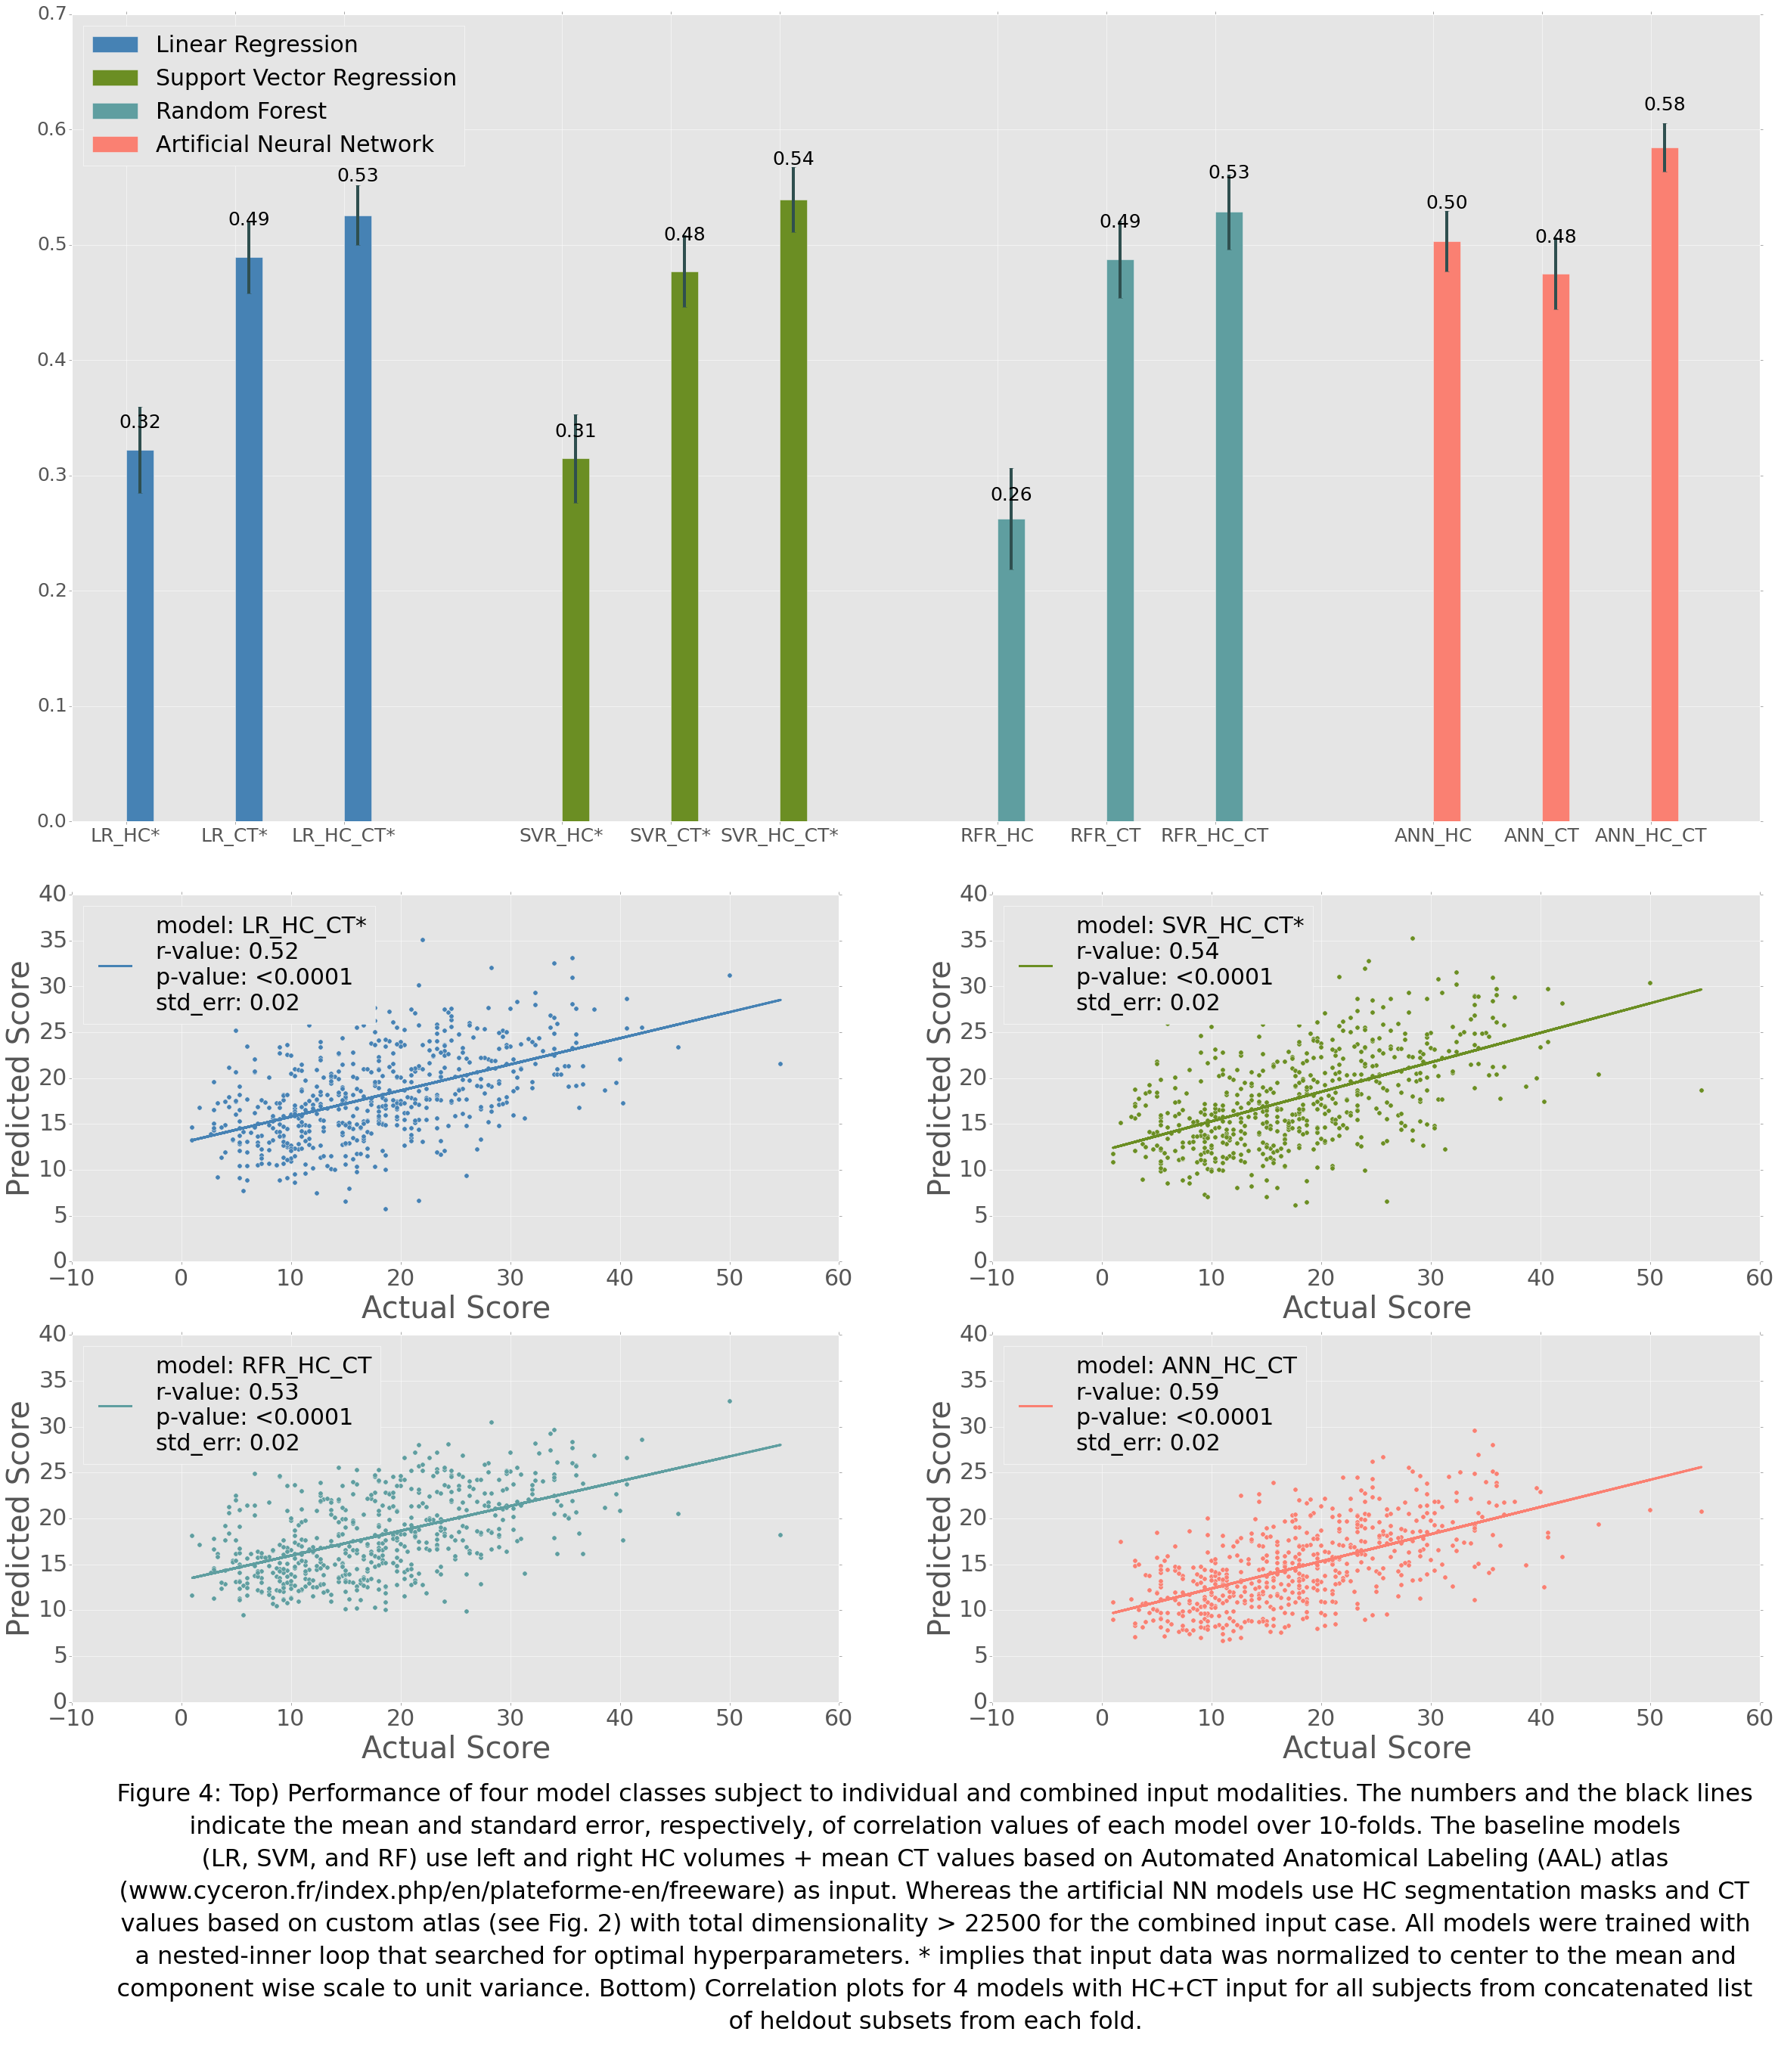

In [172]:
# Boxplots for CV statistics (r, mse, R2)
stat_measure_list = [boxplot_config_r,boxplot_config_MSE] #boxplot_config_MSE
stat_measure_names = ['Pearson r', 'RMSE'] #'MSE'
from matplotlib.artist import setp
font_small = 25
font_med = 30
font_large = 40

#custom_cols = ['LR_L1*','LR_L1_infl*', 'SVR*', 'SVR_infl*', 'RFR', 'RFR_infl','ANN_HC_CT']
custom_cols = ['LR_HC*','LR_CT*','LR_HC_CT*','SVR_HC*','SVR_CT*','SVR_HC_CT*','RFR_HC','RFR_CT','RFR_HC_CT',
               'ANN_HC','ANN_CT','ANN_HC_CT']
boxplot = False
errorbarplot = True
scatterplot = True

my_colors = ['steelblue', 'olivedrab', 'cadetblue', 'salmon']
plt.figure()
ax1 = plt.subplot2grid((4,2), (0,0), colspan=2,rowspan=2)
ax2 = plt.subplot2grid((4,2), (2,0))
ax3 = plt.subplot2grid((4,2), (2,1))
ax4 = plt.subplot2grid((4,2), (3,0))
ax5 = plt.subplot2grid((4,2), (3,1))

ax_list = [ax1,ax2,ax3,ax4,ax5]

if errorbarplot:
    custom_r_means = []
    custom_r_medians = []
    custom_r_sems = []    
    custom_mse_means = []
    custom_mse_sems = []
    for c, col in enumerate(custom_cols):
        custom_r_means.append(r_means[col][0])
        custom_r_medians.append(r_medians[col][0])
        custom_r_sems.append(r_sems[col][0])
        custom_mse_means.append(mse_means[col][0])        
        custom_mse_sems.append(mse_sems[col][0])
        
    x_r = np.array([0,1,2,4,5,6,8,9,10,12,13,14])  # padding to better appearance 
    x_mse = 0.5 + x_r 
    #plt.bar(x, np.array(custom_r_means), yerr=np.array(custom_r_sems))
    width = 0.25                    # bar width

    #fig, ax = plt.subplots()


    rects1 = ax1.bar(x_r[:3], custom_r_means[:3],                  # data
                    width,                          # bar width
                    color=my_colors[0],        # bar colour
                    yerr=custom_r_sems[:3],               # data for error bars
                    error_kw={'ecolor':'darkslategrey',    # error-bars colour
                             'linewidth':4},       # error-bar width
                    label = 'Linear Regression')
    
    rects2 = ax1.bar(x_r[3:6], custom_r_means[3:6],                  # data
                    width,                          # bar width
                    color=my_colors[1],        # bar colour
                    yerr=custom_r_sems[3:6],               # data for error bars
                    error_kw={'ecolor':'darkslategrey',    # error-bars colour
                             'linewidth':4},
                    label = 'Support Vector Regression')
    
    rects3 = ax1.bar(x_r[6:9], custom_r_means[6:9],                  # data
                    width,                          # bar width
                    color=my_colors[2],        # bar colour
                    yerr=custom_r_sems[6:9],               # data for error bars
                    error_kw={'ecolor':'darkslategrey',    # error-bars colour
                             'linewidth':4},
                     label = 'Random Forest')
    
    rects4 = ax1.bar(x_r[9:], custom_r_means[9:],                  # data
                    width,                          # bar width
                    color=my_colors[3],        # bar colour
                    yerr=custom_r_sems[9:],               # data for error bars
                    error_kw={'ecolor':'darkslategrey',    # error-bars colour
                             'linewidth':4},
                    label = 'Artificial Neural Network')
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    
    plot_mse = False
    if plot_mse: 
        rects5 = ax.bar(x_mse[:3], custom_mse_means[:3],                  # data
                        width,                          # bar width
                        color=my_colors[0],        # bar colour
                        yerr=custom_mse_sems[:3],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4})

        rects6 = ax.bar(x_mse[3:6], custom_mse_means[3:6],                  # data
                        width,                          # bar width
                        color=my_colors[1],        # bar colour
                        yerr=custom_mse_sems[3:6],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4})

        rects7 = ax.bar(x_mse[6:9], custom_mse_means[6:9],                  # data
                        width,                          # bar width
                        color=my_colors[2],        # bar colour
                        yerr=custom_mse_sems[6:9],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4})

        rects8 = ax.bar(x_mse[9:], custom_mse_means[9:],                  # data
                        width,                          # bar width
                        color=my_colors[3],        # bar colour
                        yerr=custom_mse_sems[9:],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4})
        autolabel(rects5)
        autolabel(rects6)
        autolabel(rects7)
        autolabel(rects8)

    #Plot annotations 
    ax1.set_xlim(-0.5,max(x_r)+1)
    ax1.set_xticks(x_r)
    ax1.set_xticklabels(custom_cols)
    ax1.tick_params(labelsize=font_small)
    #ax1.set_yticks(fontsize=font_med)
    ax1.legend(fontsize=font_med, loc=2)
    
if boxplot:
    plt.figure()
    for sm, stat_measure in enumerate(stat_measure_list):
        plt.subplot(2,1,sm+1)
        df_array = pd.DataFrame(dict([ (k,pd.Series(v[0])) for k,v in stat_measure.iteritems() ]))
        bplot = df_array.boxplot(column=custom_cols, fontsize=font_large)
        #plt.xlabel('Method',fontsize=font_large)
        plt.ylabel(stat_measure_names[sm],fontsize=font_large)
        plt.xticks(fontsize=font_med)
        #plt.ylim([0.3,0.75])
        plt.yticks(fontsize=font_small)
        setp(bplot['boxes'], linewidth=4)
        setp(bplot['whiskers'], linewidth=4)
        setp(bplot['fliers'], marker='^',color='Tomato',markersize=10)
        setp(bplot['medians'], linewidth=4)

if scatterplot:
    #plt.figure()
    
    for k, key in enumerate(['LR_HC_CT*','SVR_HC_CT*', 'RFR_HC_CT', 'ANN_HC_CT']):
        x = np.hstack(actual_CV_scores[key][0])
        y = np.hstack(predicted_CV_scores[key][0])

        #plt.subplot(2,2,k+1)
        ax_list[k+1].scatter(x, y, c=my_colors[k], s=40)
        fit = np.polyfit(x,y,1)
        fit_fn = np.poly1d(fit) 
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        if p_value < 0.0001:
            p_value_sig = '<0.0001'
        else:
            p_value_sig = str(p_value)

        #Plot annotations
        label_str = 'model: {}'.format(key) + '\n' + 'r-value: {:04.2f}'.format(r_value) + '\n' + 'p-value: ' + p_value_sig + '\n' + 'std_err: {:04.2f}'.format(std_err) 
        # fit_fn is now a function which takes in x and returns an estimate for y
        ax_list[k+1].plot(x, fit_fn(x),linewidth=3, c=my_colors[k], label=label_str)
        #plt.title(model_choice,fontsize=font_large)
        ax_list[k+1].set_ylim(0,40)
        ax_list[k+1].set_xlabel('Actual Score',fontsize=font_large)
        ax_list[k+1].set_ylabel('Predicted Score',fontsize=font_large)            
        ax_list[k+1].legend(fontsize=font_med,loc=2)
        ax_list[k+1].tick_params(labelsize=font_med)
        
        #ax_list[k+1].set_yticks(fontsize=font_med)
        #plt.title('Model Class: {}'.format(key))
        
my_caption = '''
            Figure 4: Top) Performance of four model classes subject to individual and combined input modalities. The numbers and the black lines 
            indicate the mean and standard error, respectively, of correlation values of each model over 10-folds. The baseline models 
            (LR, SVM, and RF) use left and right HC volumes + mean CT values based on Automated Anatomical Labeling (AAL) atlas 
            (www.cyceron.fr/index.php/en/plateforme-en/freeware) as input. Whereas the artificial NN models use HC segmentation masks and CT 
            values based on custom atlas (see Fig. 2) with total dimensionality > 22500 for the combined input case. All models were trained with
            a nested-inner loop that searched for optimal hyperparameters. * implies that input data was normalized to center to the mean and 
            component wise scale to unit variance. Bottom) Correlation plots for 4 models with HC+CT input for all subjects from concatenated list
            of heldout subsets from each fold. 
'''

plt.figtext(.5, -0.04, my_caption, fontsize=32, ha='center',linespacing=1.5)

#plt.show()
save_fig = True
if save_fig:
    fig1 = plt.gcf()
    fig1.savefig('/projects/nikhil/ADNI_prediction/visuals/HBM_Models_Corr_Stats.png', bbox_inches='tight')

In [ ]:
# Compute scores and MSEs

y_cv_pred = test_clf.predict(exemplar_X)
y_test_pred = test_clf.predict(test_data['X'])

x_data_array = [exemplar_y,test_data['y']]
y_data_array = [y_cv_pred,y_test_pred]
lable_array = ['CV train performance','test performance']

# only test perf
#x_data_array = [test_data['y']]
#y_data_array = [y_test_pred]
#lable_array = ['test performance']

plt.figure()
font_small = 8
font_med = 16
font_large = 24
no_of_plots = len(lable_array)
plt.style.use('ggplot')
plt_col = no_of_plots
plt_row = 1

for i in np.arange(no_of_plots):
    x = x_data_array[i]
    y = y_data_array[i]

    plt.subplot(plt_row,plt_col,i+1)
    plt.scatter(x, y, c='crimson', label=lable_array[i],s=40)
    fit = np.polyfit(x,y,1)
    fit_fn = np.poly1d(fit) 
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    if p_value < 0.0001:
        p_value_sig = '<0.0001'
    else:
        p_value_sig = str(p_value)
        
    label_str = 'r-value: {:04.2f}'.format(r_value) + '\n' + 'p-value: ' + p_value_sig + '\n' + 'std_err: {:04.2f}'.format(std_err) 
    # fit_fn is now a function which takes in x and returns an estimate for y
    plt.plot(x, fit_fn(x),linewidth=3, label=label_str)
    plt.title(model_choice,fontsize=font_large)
    plt.xlabel('Actual Score',fontsize=font_large)
    plt.ylabel('Predicted Score',fontsize=font_large)            
    plt.legend(fontsize=font_med,loc=2)

if feat_imp:
    plt.figure()
    #plt.subplot(plt_row,plt_col,4)
    x_pos = np.arange(len(feature_cols))
    
    if model_choice == 'RFR':
        feature_wts = test_clf.feature_importances_
    elif model_choice == 'SVR':
        feature_wts = np.squeeze(test_clf.coef_)
    elif model_choice == 'LR_L1':
        feature_wts = np.squeeze(test_clf.coef_)
    else: 
        print 'no feature_wt vector found'
        
    sorted_feat_idx = np.argsort(np.abs(feature_wts))[::-1]        
    plt.bar(x_pos,feature_wts[sorted_feat_idx],color='crimson')
    plt.ylabel('Feature Importance',fontsize=font_large)
    #Sort the feature name list as well 
    sorted_feature_cols = []
    for i,sort_idx in enumerate(sorted_feat_idx):
        sorted_feature_cols.append(feature_cols[sort_idx])

    plt.xticks(x_pos,sorted_feature_cols,rotation=70,fontsize=font_small)
    
plt.show()

In [ ]:
#Plot montages (across methods)
mont_data_dir = '/projects/nikhil/ADNI_prediction/caffe_output/montage_data/'
cats = ['LR_L1','SVR','RFR','LR_L1_infl','SVR_infl','RFR_infl'] #Montage Categories: methods / modalities
file_str = 'corr_data_{}_T1.pkl'
#cats = ['L_HC','R_HC','HC','HC_CT'] #Montage Categories: methods / modalities
#file_str = 'corr_data_{}_T11.pkl'

n_rows = 2
n_cols = 3

plt.figure()
plt.style.use('ggplot')
font_small = 8
font_med = 16
font_large = 24

for c, cat in enumerate(cats):
    if cat == 'HC_CT':
        file_str = 'corr_data_{}_T11.pkl'
        
    pkl_file = open(mont_data_dir + file_str.format(cat), 'rb')
    montage_data = pickle.load(pkl_file)
    pkl_file.close()    
    x = montage_data['predicted_score']
    y = montage_data['actual_score']
        
    plt.subplot(n_rows,n_cols,c+1)
    plt.scatter(x, y, c='crimson',s=20)
    fit = np.polyfit(x,y,1)
    fit_fn = np.poly1d(fit) 
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)      
    if p_value < 0.0001:
        p_value_sig = '<0.0001'
    else:
        p_value_sig = '{:.5f}'.format(p_value)
        
    label_str = 'r-value: {:04.2f}'.format(r_value) + '\n' + 'p-value: ' + p_value_sig + '\n' + 'std_err: {:04.2f}'.format(std_err) 
    # fit_fn is now a function which takes in x and returns an estimate for y
    plt.plot(x, fit_fn(x),linewidth=3, label=label_str)        
    title_str = 'Heldout Testset, modality: {}'.format(cat)  #heldout Test set
    plt.title(title_str,fontsize=font_med)
    plt.xlabel('Actual Score',fontsize=font_med)
    plt.ylabel('Predicted Score',fontsize=font_med)            
    plt.legend(fontsize=font_med,loc=2)

plt.show()

In [ ]:
# Additional Scripts 
# Concat of Train + Valid (to generate multi-folds)
train_file = '/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_seg_fused_train.pkl'
valid_file = '/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_seg_fused_valid.pkl'
t_data = pd.read_pickle(train_file)
v_data = pd.read_pickle(valid_file)
frames = [t_data, v_data]
result = pd.concat(frames)
result.to_pickle("/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_seg_fused_train_plus_val.pkl")

# Generatng K-Folds
#sampx = 100 #Train + Valid samples
#foldx = 10   
#kf = KFold(sampx, n_folds=foldx,shuffle=True)

#for train, test in kf:
#    print("%s %s" % (train, test))

In [ ]:
#save k-fold UIDs
kf_uid_file = '/projects/nikhil/ADNI_prediction/input_datasets/cli_ct_heldout_KFold_UIDs.pkl'
heldout_UIDs={'heldout_UIDs':test_data['U']}
f = open(kf_uid_file, 'wb')
pickle.dump(heldout_UIDs, f)
f.close()

In [104]:
max(x_mse)

14.5